# Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
import cufflinks as cf; cf.go_offline()

### Missing values

In [11]:
df = pd.read_feather('removed_duplicated_columns.feather')

In [12]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

In [13]:
missing_percentage.describe()

count    767.000000
mean       9.748248
std       27.342557
min        0.000000
25%        0.002203
50%        0.005507
75%        0.011015
max       99.998899
dtype: float64

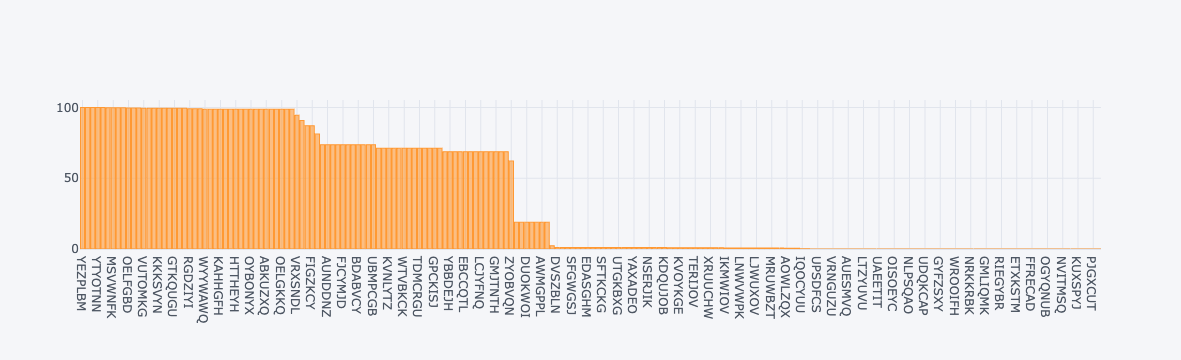

In [14]:
missing_percentage.sort_values(ascending=False).head(200).iplot(kind='bar')

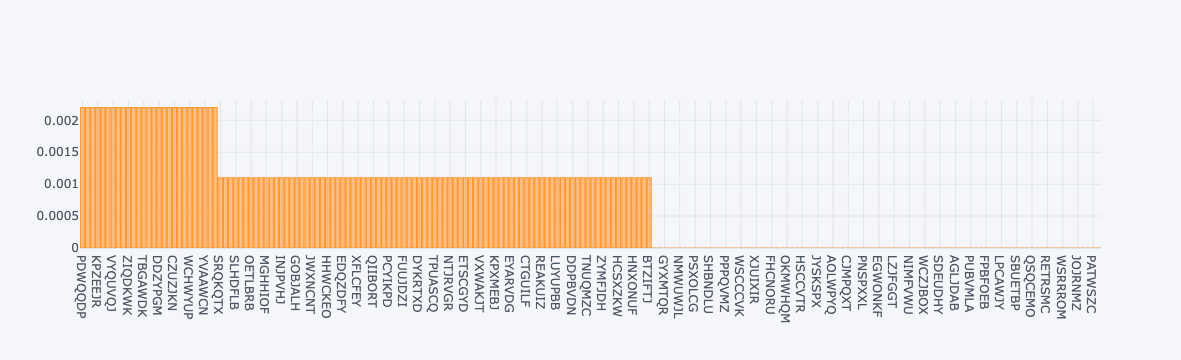

In [15]:
missing_percentage.sort_values(ascending=False).tail(200).iplot(kind='bar')

### Unique values

In [89]:
df.nunique().describe()

count       767.000000
mean      21589.123859
std      111197.584291
min           1.000000
25%          14.000000
50%          81.000000
75%         331.000000
max      723293.000000
dtype: float64

### Target analysis

In [16]:
target_test = 'TLJYWBE'
failure_thd = 1e-5
target_test_col = df[target_test]

In [17]:
target_test_col.isna().sum()

16770

In [18]:
(target_test_col >= failure_thd).value_counts()

False    726224
True         64
Name: TLJYWBE, dtype: int64

### Correlations

In [55]:
sample_for_corr_calc = df.sample(frac=0.1, random_state=42)

In [56]:
valid_cols = missing_percentage[missing_percentage < 50].index
dtypes = df.dtypes
float_cols = [c for c in dtypes[dtypes == 'float64'].index.tolist() if c in valid_cols]
len(float_cols)

658

In [58]:
from dask.diagnostics import ProgressBar
import dask.dataframe as dd

ddf = dd.from_pandas(sample_for_corr_calc, npartitions=8)

with ProgressBar():
    correlation_matrix = ddf[float_cols].corr().compute()

[########################################] | 100% Completed |  3min 39.4s


In [59]:
melted_corr = correlation_matrix.stack().reset_index()
melted_corr.columns = ['col1', 'col2', 'corr']
melted_corr = melted_corr[melted_corr['col1'] != melted_corr['col2']]

In [60]:
melted_corr = melted_corr.sort_values(by='corr', ascending=False)
melted_corr.head(50)

,col1,col2,corr
74684,IFZDTPK,CXQMCRY,1.000000
74043,CXQMCRY,IFZDTPK,1.000000
106753,JNEVNAR,RZPQSGM,1.000000
106111,RZPQSGM,JNEVNAR,1.000000
70823,HHWCKEO,LTCKGYN,1.000000
70182,LTCKGYN,HHWCKEO,1.000000
72756,JMPVBOV,SLHDFLB,1.000000
73397,SLHDFLB,JMPVBOV,1.000000
71469,INJPVHJ,LVMHJCI,1.000000
72110,LVMHJCI,INJPVHJ,1.000000
